# Workshop OpenDays 2023: Modelling & Analytics

## Estimate Wind Turbine production under a given climate

The objectives of this part are:

* Demonstrate how to read and process a meteorological time series so to get a climate.
* Compute a wind-turbine yield by applying its power curve to the climate.
* Expand the analysis to consider sector-wise variations of the climate.

# First let us prepare our environment.

In [1]:
#@title
## Get data from GitHub
import os, urllib.request 
url = 'https://github.com/calvr/openDays2023-ma/raw/main/capel_trimmed.nc'
dst = os.path.join('/content/sample_data', os.path.basename(url))
if not os.path.isfile(dst):
  urllib.request.urlretrieve(url, dst)

assert os.path.isfile(dst), f"Failed to access dataset! Something went wrong with download, please repeat..."
print(f"{os.path.basename(dst)} copied to {os.path.dirname(dst)}/")

## Get data from Google Drive
# import os, google
# google.colab.drive.mount("/content/drive", force_remount=True)
# assert os.path.isfile("/content/drive/MyDrive/Colab Notebooks/capel_trimmed.nc"), "Failed to access data! Please correct this by uploading the file"
# !cp "/content/drive/MyDrive/Colab Notebooks/capel_trimmed.nc" "/content/sample_data/capel_trimmed.nc"
# print("capel_trimmed.nc copied to ./sample_data/")
# google.colab.drive.flush_and_unmount()

capel_trimmed.nc copied to /content/sample_data/


In [2]:
import numpy as np
import xarray as xr
import scipy as sp
import scipy.stats
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings( "ignore", module = "matplotlib*" )

In [3]:
%matplotlib inline
# matplotlib.use("TKAgg")  # use this instead in your program if you want to use Tk as your graphics backend.

### Define inputs: meteorological measurements file and turbine data

We will use the Capel dataset that [was made public by DTU](https://doi.org/10.11583/DTU.14135627). This resource is a collection of three meteorological masts that includes 6 years of measurements, starting in 1989, attained at Capel Cynon in Wales, UK. As it is standard in wind resource measurements the data was attained by cup anemometers and wind vanes and time-integrated into 10 minute records.

In [4]:
ncFileName = dst  # netcdf file with data

## V80 power curve (publicly available)
## https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/WindTurbines.html
wsV80 = np.arange(0, 36, 1)  # wind speeeds for power curve
powerV80 = np.array([   0,    0,    0,    0,   66,  154,  282,  460,  696,  996, 1341,
                     1661, 1866, 1958, 1988, 1997, 1999, 2000, 2000, 2000, 2000, 2000,
                     2000, 2000, 2000, 2000,    0,    0,    0,    0,    0,    0,    0,
                        0,    0,    0])  # power at each wind speed (kW)
rhoV80 = 1.225  # kg/m^3
diameterV80 = 80  # m

Other definitions: Wind Speed (WS) and Wind Direction (WD) bins

In [5]:
## define WS bins
wsBinLimits = np.arange(0, 36, 1)
wsBins = .5 * (wsBinLimits[1:] + wsBinLimits[:-1])
nWsBins = len(wsBins)

## define WD bins
make_int_if_whole_number = lambda x: int(x) if x.is_integer() else x
nWdBins = 12
wdBinSize = make_int_if_whole_number(360 / nWdBins)
wdHalfBinSize = make_int_if_whole_number(wdBinSize / 2)
wdBins = np.arange(0, 360, wdBinSize)
wdBinLimits = np.append(wdBins, 360) - wdHalfBinSize

## Read meteorological data

The data is available as a NetCDF file. We can read this in several ways. The most basic is using `netCDF4` directly. However let us use `XArray` as it allows to convert to a `Pandas` DataFrame easily and it processes the metadata associated with the signals in the file.

In [6]:
## Simply use XArray (faster due to low-level routines)
ds = xr.open_dataset(ncFileName)
df = ds.to_dataframe()  # convert to Pandas DataFrame

Let us scrutinize this data...

In [7]:
df.head()

,ws50_m1,ws40_m1,TI_ws40_m1,ws40_m1s,ws32_m1,ws25_m1,TI_ws25_m1,ws25_m1s,ws20_m1,ws15_m1,...,ws25_m2s,ws20_m2,ws15_m2,ws10_m2s,ws40_m3s,ws32_m3,ws25_m3s,ws20_m3,ws15_m3,ws10_m3s
time,,,,,,,,,,,,,,,,,,,,,
1989-05-01 00:10:00,12.13,11.88,0.0,11.62,11.80,11.49,0.0,11.58,NaN,11.15,...,7.13,6.98,6.66,6.42,NaN,8.88,NaN,8.51,8.45,NaN
1989-05-01 00:20:00,12.18,11.95,0.0,11.68,11.91,11.68,0.0,11.72,NaN,11.39,...,7.41,7.20,6.85,6.53,NaN,8.65,NaN,8.19,8.09,NaN
1989-05-01 00:30:00,11.12,10.92,0.0,10.72,10.92,10.79,0.0,10.85,NaN,10.40,...,7.82,7.54,7.24,7.11,NaN,8.92,NaN,8.56,8.39,NaN
1989-05-01 00:40:00,10.70,10.48,0.0,10.33,10.48,10.27,0.0,10.31,NaN,9.99,...,7.32,7.13,6.84,6.54,NaN,8.64,NaN,8.27,8.19,NaN
1989-05-01 00:50:00,10.73,10.51,0.0,10.32,10.41,10.26,0.0,10.30,NaN,9.93,...,7.37,7.24,7.05,6.80,NaN,8.34,NaN,7.93,7.93,NaN


and let us check details on the first signal, `ws50_m1`:

In [8]:
print(f"Checking signal '{df.columns[0]}'\n")
print(ds[df.columns[0]])

Checking signal 'ws50_m1'

<xarray.DataArray 'ws50_m1' (time: 332794)>
array([12.13, 12.18, 11.12, ...,  1.91,  1.84,  2.13])
Coordinates:
  * time     (time) datetime64[ns] 1989-05-01T00:10:00 ... 1995-08-31T23:50:00
Attributes:
    height:                   50.0
    instrument_manufacturer:  vector instruments
    instrument_spec:          a100r
    instrument_type:          cup
    instrument_description:   Cup anemometer from Vector Instruments
    signal_type:              s
    standard_name:            wind_speed
    long_name:                Wind Speed
    concept_id:               http://data.windenergy.dtu.dk/controlled-termin...
    definition:               wind speed from cup or propellor
    units:                    m/s
    ancillary_variables:      ws50_m1_qc


What we have here is a wind speed (WS) signal measured by a cup anemometer at 50 m height. This means it must be a positive quantity always (scalar) as it is the magnitude of the horizontal velocity vector associated with the wind.

The signal's name is `ws50_m1` indicating it is from mast 1. We can also find the following signals in the dataset:

In [9]:
df.columns

Index(['ws50_m1', 'ws40_m1', 'TI_ws40_m1', 'ws40_m1s', 'ws32_m1', 'ws25_m1',
       'TI_ws25_m1', 'ws25_m1s', 'ws20_m1', 'ws15_m1', 'ws15_m1s', 'ws10_m1',
       'TI_ws10_m1', 'ws10_m1s', 'wd40_m1', 'wd25_m1', 'wd10_m1', 'precip',
       'wd40_m2', 'wd25_m2', 'wd10_m2', 'wd40_m3', 'wd25_m3', 'wd10_m3',
       'ws40_m2s', 'ws32_m2', 'ws25_m2s', 'ws20_m2', 'ws15_m2', 'ws10_m2s',
       'ws40_m3s', 'ws32_m3', 'ws25_m3s', 'ws20_m3', 'ws15_m3', 'ws10_m3s'],
      dtype='object')

Below is a brief description of some of the signals available:

* `ws50_m1_qc`, a signal with a flag stating the quality check for `ws50_m1`.
* `wd40_m1`, a wind direction (WD) signal from a wind vane mounted at 40 m.
* `wd25_m2` and `wd40_m2` are the equivalent topmost WS and WD signals for mast 2.
* `ws40_m3s` and `wd40_m3` are the equivalent topmost WS and WD signals for mast 3.

We have an image below that was provided with the data in [*Capel UK site summary*](https://gitlab.windenergy.dtu.dk/fair-data/winddata-revamp/winddata-documentation/-/blob/master/capel.md).

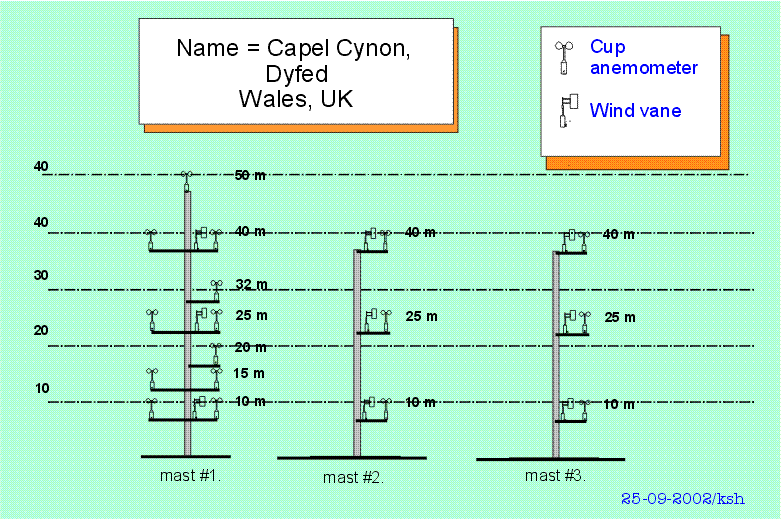

For demonstration purposes we will directly select the highest WS and WD signals from mast 1, `ws50_m1` and `wd40_m1`, and pair these together. 

In [10]:
wsSignalName = 'ws50_m1'  # wind speed signal name
wdSignalName = 'wd40_m1'  # wind direction signal name

print(f"\nChecking signal '{wdSignalName}'\n")
print(ds[wdSignalName])


Checking signal 'wd40_m1'

<xarray.DataArray 'wd40_m1' (time: 332794)>
array([189.45, 186.9 , 185.28, ..., 354.26,   7.95, 298.24])
Coordinates:
  * time     (time) datetime64[ns] 1989-05-01T00:10:00 ... 1995-08-31T23:50:00
Attributes:
    height:                   40.0
    instrument_manufacturer:  vector instruments
    instrument_spec:          w200
    instrument_type:          vane
    instrument_description:   Wind vane from Vector Instruments
    signal_type:              d
    standard_name:            wind_from_direction
    long_name:                Wind From Direction
    concept_id:               http://data.windenergy.dtu.dk/controlled-termin...
    definition:               wind direction
    units:                    deg
    ancillary_variables:      wd40_m1_qc


Let us find invalid records in the signals and mark these as `NaN`. The rules we will apply are:

* WD should be between [0, 360[
* WS should be positive $\Rightarrow$ WS > 0
* Reject unreasonable high WS values, e.g. anything above 100 m/s

In [11]:
# store signals as ws and wd for easy access
ws = df[wsSignalName]
wd = df[wdSignalName]

invalid = ws.isna() | wd.isna()  # start by those already marked as NaN
invalid = invalid | (wd >= 360) | (wd < 0)  # disregard out-of-bounds wd
invalid = invalid | ~(ws > 0) | (ws > 99) # disregard ws <= 0 and unreasonable high values

ws[invalid] = np.nan
wd[invalid] = np.nan

Let us now compute our availability: from the full ammount of records we could have, how many are actually valid?

In [12]:
print(f"""
timestamps range from {ws.index.min()} to {ws.index.max()}
in a total of {ws.index.size} records
""")

availability = sum(~ws.isna()) / ws.size
print(f"availability = {availability*100:.1f}%")


timestamps range from 1989-05-01 00:10:00 to 1995-08-31 23:50:00
in a total of 332794 records

availability = 99.8%


Exercise: But is this value correct? Is the number of records the total one we should be using?

In [13]:
#@title
timeRange = ws.index.max() - ws.index.min()
nExpectedRecords = int(timeRange.total_seconds() / 600)
availability = sum(~ws.isna()) / nExpectedRecords

print(f"""
if we subtract the timestamps we get
the following time range: {timeRange}
which is equivalent to {nExpectedRecords} periods of 10 minutes

so the correct availability is:
availability = {availability*100:.1f}%
""")


if we subtract the timestamps we get
the following time range: 2313 days 23:40:00
which is equivalent to 333214 periods of 10 minutes

so the correct availability is:
availability = 99.7%



## Fit Weibull distribution to whole data

A good approximation for the probability distribution of the WS magnitude is the [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution).

* CDF is $F_{w}(u) = 1 - e^{-\left(u/A\right)^K}$
* PDF is $f_{w}(u) = \frac{dF_{w}(u)}{du} = \frac{K}{A} \, \left(\frac{u}{A}\right)^{K-1} \, e^{-\left(u/A\right)^K}$

where $u$ is the WS magnitude and the Weibull scale and shape parameters are $A$ and $K$.

We will fit a Weibull distribution to the WS time series based on a Maximum Likelihood Estimation (MLE) approach. Note that for wind resource assessment there are other methods employed wich focus on the usefull WS range where wind turbines operate (c.f. *European Wind Atlas*, 1997).

In [14]:
## Define some useful functions
CDF = lambda ws, A, K: 1 - np.exp(-(ws/A)**K)
iCDF = lambda P, A, K: A * (-np.log(1 - P))**(1./K)
PDF = lambda ws, A, K: K/A * (ws/A)**(K-1) * np.exp(-(ws/A)**K)

def fitWeibull_mle(u):
    """
    Fit a Weibull distribution to a sample of WindSpeed values through a
    generic Maximum Likelihood Estimation (MLE) approach.
    """
    u = np.atleast_1d(np.copy(u))
    if 0 == len(u) or np.isnan(u).all() or not (np.nanmax(u) > 0):
        return np.nan, 2.0
    K, _, A = sp.stats.weibull_min.fit(u[~np.isnan(u)], 2, floc=0, scale=np.nanmean(u))
    A = A if K > 0 and A > 0 else np.nan
    return A, K


Afull, Kfull = fitWeibull_mle(ws)

print(f"Weibull A = {Afull:g} m/s,  K = {Kfull:g}")

Weibull A = 9.49 m/s,  K = 2.25201


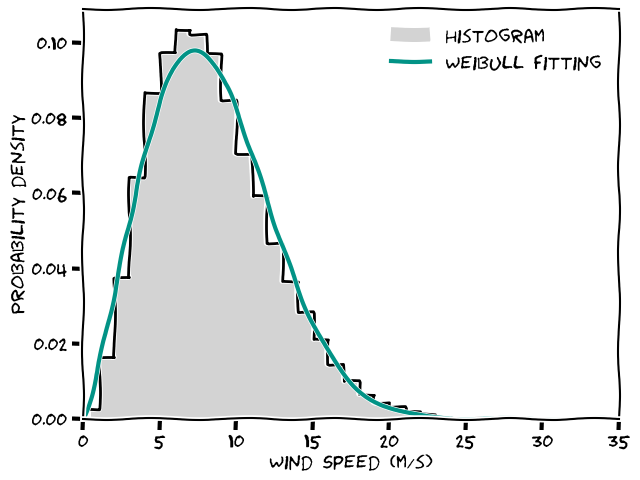

In [15]:
nValidRecords = sum(~ws.isna())  # we disregard missing values
#nValidRecords = nExpectedRecords  # we assume missing values distribution to be same of available records
wsHist, _ = np.histogram(ws, bins=wsBinLimits, density=False)
wsHistDensity = wsHist/nValidRecords/np.diff(wsBinLimits)

plt.xkcd()  # turn on XKCD plotting style...
#plt.rcdefaults()  # default style

plt.fill_between(wsBins, wsHistDensity, step="mid", facecolor='lightgrey', edgecolor='None', label="histogram")
plt.step(wsBins, wsHistDensity, where='mid', c='k')
wsBinsFine = np.arange(0, wsBinLimits.max(), .1)
plt.plot(wsBinsFine, PDF(wsBinsFine, Afull, Kfull), c='xkcd:teal', ls='-', lw=3, label='Weibull fitting')
plt.gca().set_xlim(left=0, right=wsBinLimits.max())
plt.gca().set_ylim(bottom=0)
plt.legend(frameon=False)
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Probability density")
plt.tight_layout(pad=0.5, h_pad=None, w_pad=None, rect=None)
plt.show()

The behavior of a Wind Turbine when exposed to the wind is dependent on many factors, some related to the turbine components itself but others to the wind characteristics, e.g.:

* How is the wind distributed accross the rotor-swept area?
* Is the profile sheared in the vertical or horizontal directions?
* Is the profile veering with height?
* What effect does turbulence intensity has on the turbine operation?
* Atmospheric physics effects due to thermal stratification?

It is unfeasible to consider all these particular effects for practical applications in wind resource assessment. Hence a model is required that represents the aggregate of turbine production under these different conditions.

To represent these conditions for wind resource assessment a model is required to abstract the turbine behavior, where we consider a single power output each WS value. We call this a *power curve*. For the following exercise we will use a [V80 power curve that is publically available in `PyWake`](https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/WindTurbines.html). Mathematically we can refer to this power curve as:

$\dot{W} = \dot{W}(u)$

where $u$ is the WS at the hub-height, i.e. the centre of the wind-turbine rotor. More complex power curves will also be function of density, turbulence intensity, etc.


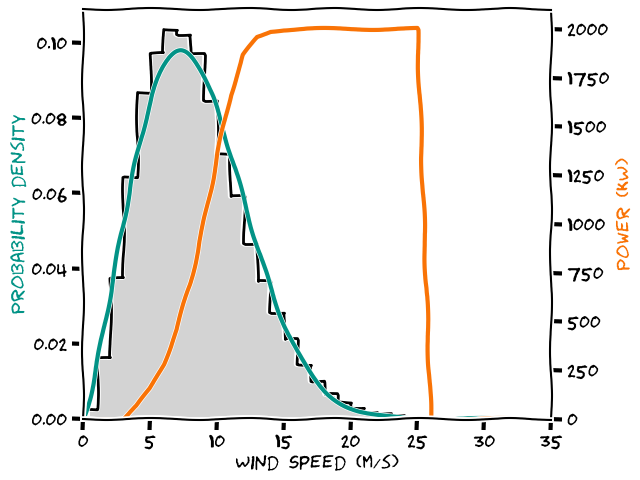

In [16]:
plt.step(wsBins, wsHistDensity, where='mid', c='k')
plt.fill_between(wsBins, wsHistDensity, step="mid", facecolor='lightgrey', edgecolor='None', label="histogram")
wsBinsFine = np.arange(0, wsBinLimits.max(), .1) 
plt.plot(wsBinsFine, PDF(wsBinsFine, Afull, Kfull), c='xkcd:teal', ls='-', lw=3, label='Weibull fitting')
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Probability density", color='xkcd:teal')
plt.gca().set_xlim(left=0, right=wsBinLimits.max())
plt.gca().set_ylim(bottom=0)
axTwin = plt.gca().twinx()
axTwin.plot(wsV80, powerV80, c='xkcd:orange', ls='-', lw=3, label='V80 power curve')
axTwin.set_ylim(bottom=0)
axTwin.set_ylabel('Power (kW)', color='xkcd:orange')
#plt.legend(frameon=False)
plt.tight_layout(pad=0.5, h_pad=None, w_pad=None, rect=None)
plt.show()

To estimate the yield, we now have to superimpose the power associated with each WS *bin* in the WS distribution. Such analysis can make use of either the histogram or the Weibull distribution. For practipal purposes we will use the Weibull distribution.

If the power curve was a continuous function we could use the PDF:

$\dot{E} = \int\limits_0^{\infty} \dot{W}(u)\,f_{w}(u)\,du$

where $E$ can be viewed as the energy converted in one hour (in units of kWh) or alternatively as the power $\dot{E}$ considering the full wind conditions given by the WS distribution (in units of kW).

However as our power curve is a discrete function, $\mathsf{\dot{W}}_{i}$ for each $\mathsf{u}_{i}$, it is preferable to use the probability related to each power bin for which the CDF can be used in an expedite way:

$p(u_{low} \le u \lt u_{hi}) = F_w(u_{hi}) - F_w(u_{lo})
\;\Rightarrow\;
\mathsf{p_i} = F_w\left(\mathsf{u}_i + \mathsf{\dfrac{\Delta u}{2}}\right)
- F_w\left(\mathsf{u}_i - \mathsf{\dfrac{\Delta u}{2}}\right)$

and the energy is attained by summing each discrete bin:

$\dot{E} = \int\limits_0^{\infty} \dot{W}(u)\,dF(u) \approx \sum\limits_i \mathsf{\dot{W}}_{i} \, p_i$

The Annual Energy Production (AEP) is the equivalent $E$ value considering one year of time span.

In [17]:
## Based on CDF
wsV80edges = np.concatenate([[wsV80[0]], 0.5*(wsV80[1:] + wsV80[:-1]), [wsV80[-1]]])
wsProb = CDF(wsV80edges[1:], Afull, Kfull) - CDF(wsV80edges[:-1], Afull, Kfull)
yieldV80 = sum(wsProb * powerV80)
print(f"""
Values based on Weibull fitting (using the CDF)
Yield = {yieldV80:g} kWh
AEP   = {yieldV80 * 365.25 * 24 / 1000:g} MWh/year
CF    = {yieldV80/ max(powerV80) * 100:.1f}%
""")


Values based on Weibull fitting (using the CDF)
Yield = 892.501 kWh
AEP   = 7823.67 MWh/year
CF    = 44.6%



### Proposed exercises:

1. How could you do the same but using the PDF in a discrete way?
2. How to do the equivalent but using the histogram data directly?

In [18]:
#@title
## Based on PDF
wsV80mid = 0.5*(wsV80[1:] + wsV80[:-1])
wsV80delta = wsV80[1:] - wsV80[:-1]
powerV80mid = 0.5*(powerV80[1:] + powerV80[:-1])
yieldV80 = sum(PDF(wsV80mid, Afull, Kfull) * wsV80delta * powerV80mid)
print(f"""
Values based on Weibull fitting (using the PDF)
Yield = {yieldV80:g} kWh
AEP   = {yieldV80 * 365.25 * 24 / 1000:g} MWh/year
CF    = {yieldV80/ max(powerV80) * 100:.1f}%
""")

## Based on histogram
powerV80mid = 0.5*(powerV80[1:] + powerV80[:-1])
wsProbHist = wsHist/nValidRecords
yieldV80 = sum(wsProbHist * powerV80mid)
print(f"""
Values based on the histogram
Yield = {yieldV80:g} kWh
AEP   = {yieldV80 * 365.25 * 24 / 1000:g} MWh/year
CF    = {yieldV80/ max(powerV80) * 100:.1f}%
""")


Values based on Weibull fitting (using the PDF)
Yield = 893.2 kWh
AEP   = 7829.79 MWh/year
CF    = 44.7%


Values based on the histogram
Yield = 871.506 kWh
AEP   = 7639.62 MWh/year
CF    = 43.6%



## Analysis per azimuth sector

To fit a Weibull distribution to the whole data may be a crude approximation. In this case the data seems well behaved but when considering wind flowing from a particular direction range, or sector, the histogram may change and thus the Weibull fitting.

Let us start by defining useful functions and check the WD bins that were defined initially.

In [19]:
neg_wd = lambda x, dx=-180: np.mod(x - dx, 360) + dx

print(f"""
What does the `neg_wd` function do?
neg_wd(  0, -15) = {neg_wd(  0, -15)}
neg_wd(  5, -15) = {neg_wd(  5, -15)}
neg_wd( 10, -15) = {neg_wd( 10, -15)}

neg_wd(343, -15) = {neg_wd(343, -15)}
neg_wd(344, -15) = {neg_wd(344, -15)}
neg_wd(345, -15) = {neg_wd(345, -15)}
neg_wd(346, -15) = {neg_wd(346, -15)}
neg_wd(347, -15) = {neg_wd(347, -15)}
""")

print(f"""
nWdBins     = {nWdBins}
wdBins      = {wdBins}
wdBinLimits = {wdBinLimits}
""")


What does the `neg_wd` function do?
neg_wd(  0, -15) = 0
neg_wd(  5, -15) = 5
neg_wd( 10, -15) = 10

neg_wd(343, -15) = 343
neg_wd(344, -15) = 344
neg_wd(345, -15) = -15
neg_wd(346, -15) = -14
neg_wd(347, -15) = -13


nWdBins     = 12
wdBins      = [  0  30  60  90 120 150 180 210 240 270 300 330]
wdBinLimits = [-15  15  45  75 105 135 165 195 225 255 285 315 345]



We can use `Pandas` to group the WD signal by sectors.

In [20]:
wdSectors = pd.cut(neg_wd(wd, wdBinLimits[0]), wdBinLimits, right=False)
wsInSectors = ws.groupby(wdSectors)
#wdBinCount = wdSectors.groupby(wdSectors).count()
wdBinCount = wsInSectors.count()
print(f"WD bin counts:\n{wdBinCount}")

WD bin counts:
wd40_m1
[-15, 15)     23384
[15, 45)      14454
[45, 75)      10537
[75, 105)     15713
[105, 135)    24585
[135, 165)    28894
[165, 195)    45196
[195, 225)    46799
[225, 255)    37875
[255, 285)    32616
[285, 315)    21318
[315, 345)    30829
Name: ws50_m1, dtype: int64


In [21]:
frequency = wdBinCount / float(wdBinCount.sum())
print(f"Frequency (%) per WD sector:\n{(frequency * 100)}")

Frequency (%) per WD sector:
wd40_m1
[-15, 15)      7.039133
[15, 45)       4.350993
[45, 75)       3.171884
[75, 105)      4.729982
[105, 135)     7.400662
[135, 165)     8.697772
[165, 195)    13.605057
[195, 225)    14.087598
[225, 255)    11.401264
[255, 285)     9.818182
[285, 315)     6.417219
[315, 345)     9.280253
Name: ws50_m1, dtype: float64


The information above is a normalized histogram under a circular dimension. One way to show the information above is in a wind-rose plot:

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 176 (\N{DEGREE SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


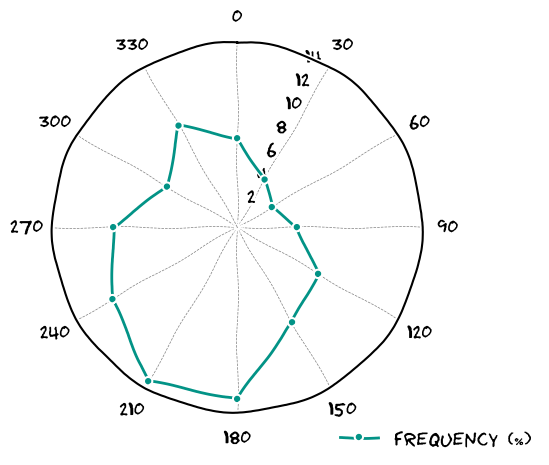

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.grid(False)
ax.set_aspect(1.0)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xticks(np.radians(wdBins))
ax.plot(np.radians(np.append(wdBins, wdBins[0])), np.append(frequency, frequency[0]) * 100, label='frequency (%)', c='xkcd:teal', marker='.', ls='-')
ax.legend(loc='lower right', bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1, 0), frameon=False) 
ax.xaxis.grid(color='k', linestyle='--', lw=.5, alpha=0.5)
#ax.yaxis.grid(color='k', linestyle='--', lw=.5, alpha=0.5)
#plt.gcf().tight_layout(pad=0.5, h_pad=None, w_pad=None, rect=None)
plt.show()

But how do the Weibull-distribution parameters change with WD sector?

In [23]:
weibPerSector = pd.DataFrame(index=wdBins, columns=['A', 'K'])
for i, k in zip(weibPerSector.index, wsInSectors.groups.keys()):
    weibPerSector.loc[i, ['A', 'K']] = fitWeibull_mle(wsInSectors.get_group(k))

weibPerSector

,A,K
0,7.377792,2.069182
30,6.674142,2.375732
60,7.028138,2.440082
90,7.67687,2.616099
120,8.873911,2.58995
150,10.876038,2.493986
180,11.293818,2.473547
210,10.495231,2.687755
240,10.296086,2.4578
270,9.71198,2.312885


We can also show this in a similar way to a wind rose:

<ipython-input-24-0163445bda86>:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cax = plt.colorbar(sm, pad=0.08)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 176 (\N{DEGREE SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


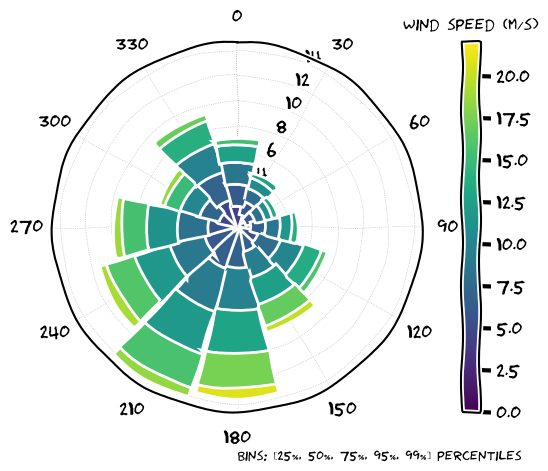

In [24]:
u25 = np.array([iCDF(.25, A, K) for A, K in zip(weibPerSector['A'], weibPerSector['K'])])
u50 = np.array([iCDF(.50, A, K) for A, K in zip(weibPerSector['A'], weibPerSector['K'])])
u75 = np.array([iCDF(.75, A, K) for A, K in zip(weibPerSector['A'], weibPerSector['K'])])
u95 = np.array([iCDF(.95, A, K) for A, K in zip(weibPerSector['A'], weibPerSector['K'])])
u99 = np.array([iCDF(.99, A, K) for A, K in zip(weibPerSector['A'], weibPerSector['K'])])

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.grid(False)
ax.set_aspect(1.0)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
a = np.radians(np.append(wdBins, wdBins[0]))
ax.set_xticks(a)
width = 2*np.pi/float(len(a))
cmap = mpl.cm.viridis
umax = np.ceil(max(u99)/2.)*2
c25 = np.array(u25 / umax * (cmap.N-1)).astype(int)
c50 = np.array(u50 / umax * (cmap.N-1)).astype(int)
c75 = np.array(u75 / umax * (cmap.N-1)).astype(int)
c95 = np.array(u95 / umax * (cmap.N-1)).astype(int)
c99 = np.array(u99 / umax * (cmap.N-1)).astype(int)
p = np.array([0, .25, .50, .75, .95, .99, 1])  # we want to pass from CDF to PMF values
dp = np.diff(p)  # mind that the last is not needed
f = np.append(frequency, frequency[0]) * 100
ax.bar(a, dp[0]*f, width, align='center', color=cmap(c25), zorder=10)
ax.bar(a, dp[1]*f, width, bottom=dp[0]*f, align='center', color=cmap(c50), zorder=10)
ax.bar(a, dp[2]*f, width, bottom=np.sum(dp[:2])*f, align='center', color=cmap(c75), zorder=10)
ax.bar(a, dp[3]*f, width, bottom=np.sum(dp[:3])*f, align='center', color=cmap(c95), zorder=10)
ax.bar(a, dp[4]*f, width, bottom=np.sum(dp[:4])*f, align='center', color=cmap(c99), zorder=10)
ax.set_xlabel('Bins: [25%, 50%, 75%, 95%, 99%] percentiles', ha='left', fontsize='x-small')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=umax))
sm.set_array([])
cax = plt.colorbar(sm, pad=0.08)
cax.ax.set_title('Wind speed (m/s)', fontsize='small', pad=10)
ax.xaxis.grid(color='k', linestyle=':', lw=.5, alpha=0.3)
ax.yaxis.grid(color='k', linestyle=':', lw=.5, alpha=0.3)
#plt.gcf().tight_layout(pad=0.5, h_pad=None, w_pad=None, rect=None)
plt.show()

Let us plot all Weibull distributions together to compare them.

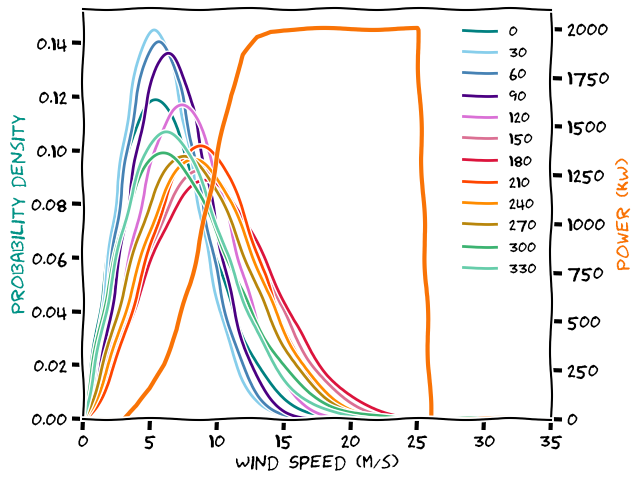

In [25]:
from cycler import cycler
myCycler = cycler(color=['teal', 'skyblue',
                         'steelblue', 'indigo', 'orchid',
                         'palevioletred', 'crimson', 'orangered',
                         'darkorange', 'darkgoldenrod', 'mediumseagreen',
                         'mediumaquamarine'])
plt.gca().set_prop_cycle(myCycler)

wsBinsFine = np.arange(0, wsBinLimits.max(), .1)
for i in weibPerSector.index:
    plt.plot(wsBinsFine, PDF(wsBinsFine, weibPerSector.loc[i,'A'], weibPerSector.loc[i,'K']), ls='-', lw=2, label=f'{i}')

plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Probability density", color='xkcd:teal')
plt.gca().set_xlim(left=0, right=wsBinLimits.max())
plt.gca().set_ylim(bottom=0)
plt.legend(frameon=False, fontsize='small')
axTwin = plt.gca().twinx()
axTwin.plot(wsV80, powerV80, c='xkcd:orange', ls='-', lw=3, label='V80 power curve')
axTwin.set_ylim(bottom=0)
axTwin.set_ylabel('Power (kW)', color='xkcd:orange')
plt.tight_layout(pad=0.5, h_pad=None, w_pad=None, rect=None)
plt.show()

### Yield per azimuth sector

Using the several Weibull fittings per WD sector we can estimate correspondent yield by superimposing the power curve. This allows to estimate which azimuth sectors are more relevant for energy conversion.

In [26]:
wsV80edges = np.concatenate([[wsV80[0]], 0.5*(wsV80[1:] + wsV80[:-1]), [wsV80[-1]]])
for i, k in zip(weibPerSector.index, wsInSectors.groups.keys()):
    weibPerSector.loc[i, ['A', 'K']] = fitWeibull_mle(wsInSectors.get_group(k))
    wsProb = (   CDF(wsV80edges[1:], weibPerSector.loc[i,'A'], weibPerSector.loc[i,'K'])
               - CDF(wsV80edges[:-1], weibPerSector.loc[i,'A'], weibPerSector.loc[i,'K'])
             )
    weibPerSector.loc[i,'yield'] = sum(wsProb * powerV80)

weibPerSector

,A,K,yield
0,7.377792,2.069182,560.332124
30,6.674142,2.375732,421.931402
60,7.028138,2.440082,478.171013
90,7.67687,2.616099,585.490063
120,8.873911,2.58995,802.061180
150,10.876038,2.493986,1106.800283
180,11.293818,2.473547,1157.915397
210,10.495231,2.687755,1070.832341
240,10.296086,2.4578,1023.390255
270,9.71198,2.312885,928.479900


If we sum the sector-wise yield we should obtain the global yield:

In [27]:
print(f"""
sum of yield per sector = {weibPerSector['yield'].sum():g} kWh
whereas global yield = {yieldV80:g} kWh
""")


sum of yield per sector = 9605.29 kWh
whereas global yield = 871.506 kWh



Exercise: Something is amiss as the yield values do not match. What is missing?

In [28]:
#@title
print("""
The yield per sector should be dependent on:
* the probability bins given by the Weibull distributions for each sector
* the probability associated with the frequency of occurrence for each sector

so we need to multiply the previously computed yield with the frequency, for each sector!
""")
weibPerSector.loc[:,'frequency'] =  frequency.values
weibPerSector.loc[:,'yield'] = weibPerSector['frequency'] * weibPerSector['yield']

print(f"""
sum of yield per sector = {weibPerSector['yield'].sum():g} kWh
whereas global yield = {yieldV80:g} kWh
""")

weibPerSector


The yield per sector should be dependent on:
* the probability bins given by the Weibull distributions for each sector
* the probability associated with the frequency of occurrence for each sector

so we need to multiply the previously computed yield with the frequency, for each sector!


sum of yield per sector = 887.352 kWh
whereas global yield = 871.506 kWh



,A,K,yield,frequency
0,7.377792,2.069182,39.442524,0.070391
30,6.674142,2.375732,18.358207,0.043510
60,7.028138,2.440082,15.167032,0.031719
90,7.67687,2.616099,27.693574,0.047300
120,8.873911,2.58995,59.357839,0.074007
150,10.876038,2.493986,96.266970,0.086978
180,11.293818,2.473547,157.535052,0.136051
210,10.495231,2.687755,150.854554,0.140876
240,10.296086,2.4578,116.679428,0.114013
270,9.71198,2.312885,91.159845,0.098182


Visualizing as a yield-rose plot:

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 176 (\N{DEGREE SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


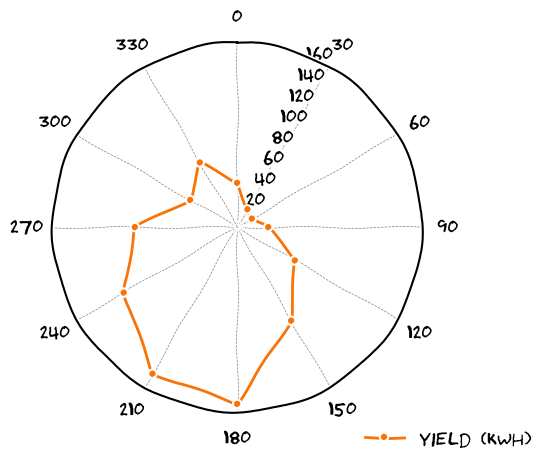

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.grid(False)
ax.set_aspect(1.0)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_xticks(np.radians(wdBins))
ax.plot(np.radians(np.append(wdBins, wdBins[0])), np.append(weibPerSector['yield'], weibPerSector['yield'][0]), label='Yield (kWh)', c='xkcd:orange', marker='.', ls='-')
ax.legend(loc='lower right', bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1, 0), frameon=False)
ax.xaxis.grid(color='k', linestyle='--', lw=.5, alpha=0.5)
#ax.yaxis.grid(color='k', linestyle='--', lw=.5, alpha=0.5)
#plt.gcf().tight_layout(pad=0.5, h_pad=None, w_pad=None, rect=None)
plt.show()